STAT 453: Deep Learning (Spring 2021)  

Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.8.2
IPython 7.18.1

torch 1.7.0


- Runs on CPU or GPU (if available)

# L03: Perceptrons

Implementation of the classic Perceptron by Frank Rosenblatt for binary classification (here: 0/1 class labels) in PyTorch

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Preparing a toy dataset

In [2]:
##########################
### DATASET
##########################

data = np.genfromtxt('../data/perceptron_toydata.txt', delimiter='\t')
X, y = data[:, :2], data[:, 2]
y = y.astype(int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


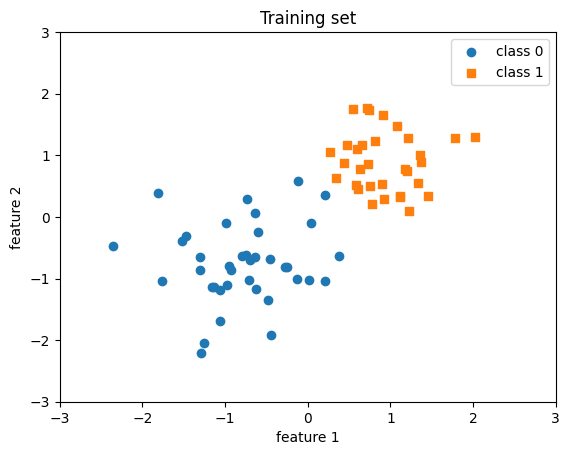

In [3]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

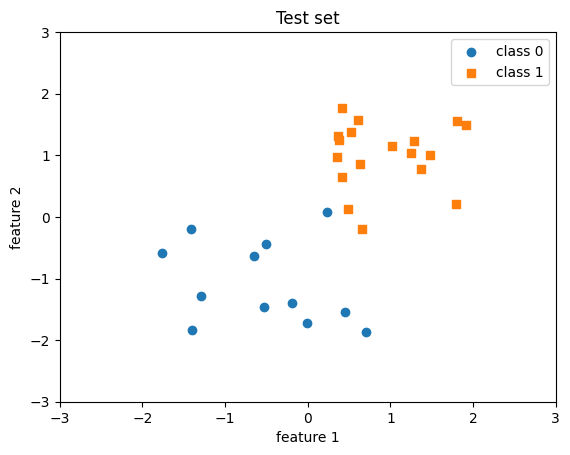

In [4]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

## Defining the Perceptron model

In [5]:
device = torch.device("mps:0" if torch.cuda.is_available() else "cpu")


class Perceptron:
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

        # placeholder vectors so they don't
        # need to be recreated each time
        self.ones = torch.ones(1)
        self.zeros = torch.zeros(1)

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias
        predictions = torch.where(linear > 0., self.ones, self.zeros)
        return predictions

    def backward(self, x, y):
        predictions = self.forward(x).reshape(-1)
        errors = y - predictions
        return errors

    def train(self, x, y, epochs):
        for _ in range(epochs):

            errors = self.backward(x, y).reshape(-1, 1)

            self.weights += torch.matmul(x.T, errors)
            self.bias += torch.sum(errors)

    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

In [41]:
device = torch.device("mps:0" if torch.cuda.is_available() else "cpu")

# Training with mini-batch
class Perceptron:
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

        # placeholder vectors so they don't
        # need to be recreated each time
        self.ones = torch.ones(1)
        self.zeros = torch.zeros(1)

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias
        predictions = torch.where(linear > 0., self.ones, self.zeros)
        return predictions

    def backward(self, x, y):
        predictions = self.forward(x).reshape(-1)
        errors = y - predictions
        return errors

    def train(self, x, y, epochs):

        __batch_size = 10

        for _ in range(epochs):
            batch_count = 0
            for start_idx in range(0, x.shape[0], __batch_size):
                x_batch = x[start_idx:start_idx + __batch_size]
                y_batch = y[start_idx:start_idx + __batch_size]

                errors = self.backward(x_batch, y_batch).reshape(-1, 1)
                print(f"errors for batch: {batch_count}: {errors}")
                batch_count += 1

                self.weights += torch.mm(x_batch.t(), errors)
                self.bias += torch.sum(errors)

    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

## Training the Perceptron

In [42]:
ppn = Perceptron(num_features=2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

x_batch torch.Size([10, 2]) weights torch.Size([2, 1])
errors torch.Size([10, 1])
errors for batch: 0: tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]])
x_batch torch.Size([10, 2]) weights torch.Size([2, 1])
errors torch.Size([10, 1])
errors for batch: 1: tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [-1.]])
x_batch torch.Size([10, 2]) weights torch.Size([2, 1])
errors torch.Size([10, 1])
errors for batch: 2: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
x_batch torch.Size([10, 2]) weights torch.Size([2, 1])
errors torch.Size([10, 1])
errors for batch: 3: tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [-1.],
        [ 0.]])
x_ba

## Evaluating the model

In [40]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 96.67%


## Evaluating the model

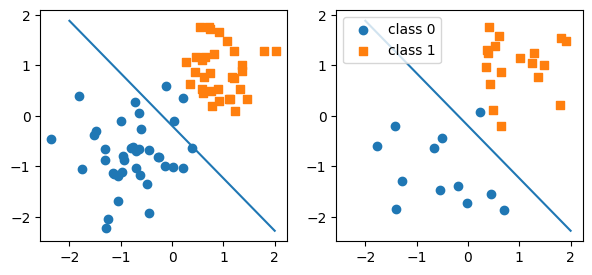

In [9]:
 ##########################
### 2D Decision Boundary
##########################

w, b = ppn.weights, ppn.bias

x0_min = -2
x1_min = ( (-(w[0] * x0_min) - b[0]) 
          / w[1] )

x0_max = 2
x1_max = ( (-(w[0] * x0_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x0_min, x0_max], [x1_min, x1_max])
ax[1].plot([x0_min, x0_max], [x1_min, x1_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()